# Capstone Project -- Flatiron Data Science Final Project

Name: Brian Caterfino

Instructor: Rafael Carrasco

Pace: Full Time

Data: https://www.kaggle.com/zynicide/wine-reviews

# WIne Review Analysis

#### In this project, I seek to showcase my knowledge gained from the Flatiron Data Science Program by using data science to analyze the Kaggle dataset chronicling 130,000 reviews of wine bottles, with features such as description, country, rating, price, and others.

The first step is to import/install all necesary python libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import string

from sklearn import preprocessing
from sklearn.utils.fixes import signature
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


from wordcloud import WordCloud

from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import nltk
import nltk.data
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer


from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

%matplotlib inline
np.random.seed(0)
from sklearn.datasets import fetch_20newsgroups
import keras
from keras.layers import LSTM, GRU, Dense, GlobalMaxPool1D, Embedding, Dropout
from keras.preprocessing import text, sequence
from keras.models import Sequential


C:\Users\Brian\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\Brian\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Obtaining Data -- Importing the Kaggle dataset into this Jupyter Notebook

Here, the data is imported via pandas into a dataframe, and then the first few elements are inspected.

In [2]:
df0 = pd.read_csv('winemag-data-130k-v2.csv', index_col=0)
df0.head(3)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


## Exploring Data Analysis

#### In the EDA phase of this project, it is crucial to get an understanding for the dataset. Attributes to look at that may help one understand their dataset are: shape, null values, features, feature value counts, datatypes, and distribution.

In [3]:
df00 = df0.drop(columns= 'taster_twitter_handle')
df00.shape

(129971, 12)

In [4]:
df00.isnull().sum()

country           63
description        0
designation    37465
points             0
price           8996
province          63
region_1       21247
region_2       79460
taster_name    26244
title              0
variety            1
winery             0
dtype: int64

In [5]:
df = df00.dropna(subset=['price'])

#### Some of the non-important features must be dropped, and some potentially useful features procured through feature engineering must be added.Also, it is important to remove or fill all null/NaN values.

In [6]:
addnonelist =['designation' , 'region_1' , 'region_2' , 'region_1' , 'taster_name' , 'country' , 'variety' , 'province']
for x in addnonelist:
    df[x].fillna('None', inplace = True)
df['Value Ratio'] = df['points'] / df['price']
df['Positive'] = 0

C:\Users\Brian\Anaconda3\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Users\Brian\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Brian\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

In [7]:
df.head(3)

,country,description,designation,points,price,province,region_1,region_2,taster_name,title,variety,winery,Value Ratio,Positive
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,None,None,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,5.800000,0
2,US,"Tart and snappy, the flavors of lime flesh and...",None,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,6.214286,0
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,None,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,6.692308,0


In [8]:
scoremean = df.points.mean()
range(len(df.points))

range(0, 120975)

In [9]:
df.points.iloc[1]

87

In [10]:
df.isnull().sum()

country        0
description    0
designation    0
points         0
price          0
province       0
region_1       0
region_2       0
taster_name    0
title          0
variety        0
winery         0
Value Ratio    0
Positive       0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120975 entries, 1 to 129970
Data columns (total 14 columns):
country        120975 non-null object
description    120975 non-null object
designation    120975 non-null object
points         120975 non-null int64
price          120975 non-null float64
province       120975 non-null object
region_1       120975 non-null object
region_2       120975 non-null object
taster_name    120975 non-null object
title          120975 non-null object
variety        120975 non-null object
winery         120975 non-null object
Value Ratio    120975 non-null float64
Positive       120975 non-null int64
dtypes: float64(2), int64(2), object(10)
memory usage: 13.8+ MB


In [12]:
df.shape

(120975, 14)

In [13]:
df.price.describe()

count    120975.000000
mean         35.363389
std          41.022218
min           4.000000
25%          17.000000
50%          25.000000
75%          42.000000
max        3300.000000
Name: price, dtype: float64

#### This graph shows the distribution of the points features.

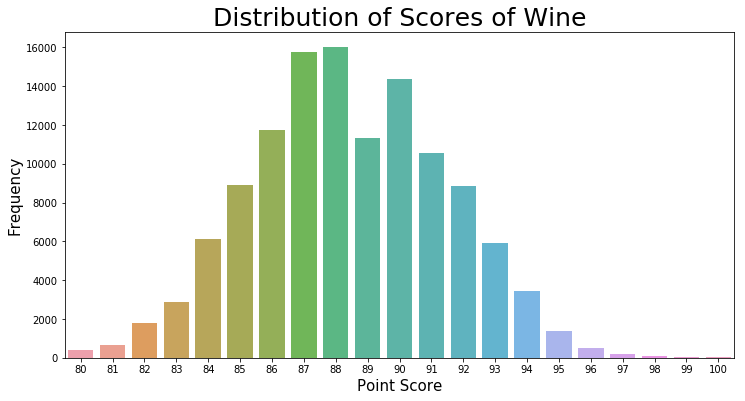

In [14]:
ptvals  = df['points'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(ptvals.index, ptvals.values, alpha=0.9)
plt.title('Distribution of Scores of Wine', fontsize=25)
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Point Score', fontsize=15)
plt.show()

In [15]:
print(df.price.corr(df.points))
print(df.price.max())
print(df.price.quantile(.999))

0.4161667418606219
3300.0
468.0260000000126


#### Now, removing some of the outlier values will make our graphs more useful, without sacrificing too much information.

In [16]:
df = df.loc[df.price < 150]
df = df.loc[df['Value Ratio'] < 10]

In [17]:
df['Value Ratio'].max()

9.88888888888889

#### There is clearly some causation between the price and the review score, but the correlation appears to be pretty low.. This scatter plot does not show much valuble informatin, so other methods must be used.

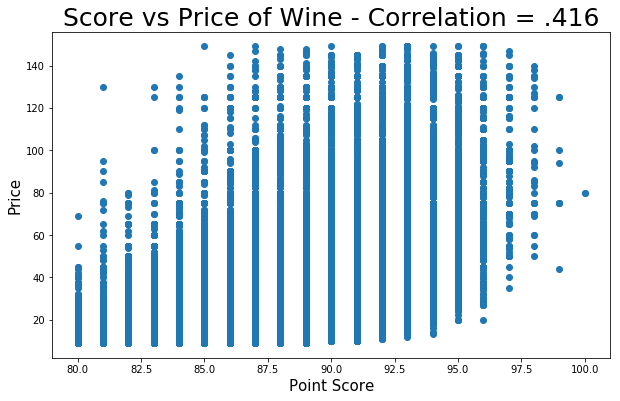

In [18]:
plt.figure(figsize=(10,6))
plt.scatter(df.points, df.price)
plt.title('Score vs Price of Wine - Correlation = .416', fontsize=25)
plt.ylabel('Price', fontsize=15)
plt.xlabel('Point Score', fontsize=15)
plt.show()

In [19]:
dfpt80= df.loc[df['points'] == 85]
dfpt80['price'].mean()

20.31933263329833

In [20]:
pointspricemeans=[]
pointspricemeans.append(df.loc[df['points'] == 80].mean())
print(pointspricemeans)

[points         80.000000
price          17.324930
Value Ratio     5.429165
Positive        0.000000
dtype: float64]


In [21]:
pointspricemeans=[]
for x in list(range(80,101)):
    z = df.loc[df['points'] == x]
    pointspricemeans.append(z['price'].mean())

#### With the outliers removed, a bar chart of the mean prices of different scores shows us the relationship more clearly. (Wuthout removing outliers, the graph continuoisly grows, instead of trending downward after 98.)

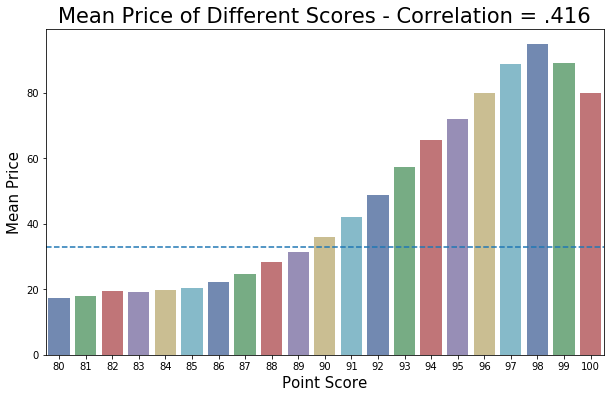

In [22]:
plt.figure(figsize=(10,6))
sns.barplot(list(range(80,101)), pointspricemeans, palette="deep", alpha = .85)
plt.axhline(df.price.mean(), ls='--')
plt.title('Mean Price of Different Scores - Correlation = .416', fontsize=21)
plt.ylabel('Mean Price', fontsize=15)
plt.xlabel('Point Score', fontsize=15)
plt.show()

In [23]:
df.price.quantile(.99)

120.0

In [24]:
df.groupby('variety', as_index=False)['price'].mean().min()[1]

9.0

#### In order to make an informative graphic, I scale the price and value features to be between 80-100, just like the points features, then plot them all together by different categories of wine.

In [25]:
min1 = df.price.min()
max1 = df.price.max()
#max1 = df.price.quantile(q = .97)

min2 = df.points.min()
max2 = df.points.max()

min3 = df['Value Ratio'].min()
max3 = df['Value Ratio'].max()

In [26]:
df['OPrice'] = df.price
df['OValue Ratio'] = df['Value Ratio']
df.opoints = df.points

C:\Users\Brian\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
df.head(2)

,country,description,designation,points,price,province,region_1,region_2,taster_name,title,variety,winery,Value Ratio,Positive,OPrice,OValue Ratio
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,None,None,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,5.800000,0,15.0,5.800000
2,US,"Tart and snappy, the flavors of lime flesh and...",None,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,6.214286,0,14.0,6.214286


In [28]:
X_std = (df.price - min1) * (100 - 80) / (max1 - min1) + 80
df.price = X_std

X_std3 = (df['Value Ratio'] - min3) * (100 - 80) / (max3 - min3) + 80
df['Value Ratio'] = X_std3

In [29]:
topfreqtypelist100 = df.variety.value_counts().index.tolist()[0:100]
topfreqtypelist10 = df.variety.value_counts().index.tolist()[0:10]

In [30]:
meanvaluelist1=[]
pricelist1=[]
scorelist1=[]
for x in topfreqtypelist100:
    z = df.loc[df['variety'] == x]
    meanvaluelist1.append(z['Value Ratio'].mean())
    pricelist1.append(z['price'].mean())
    scorelist1.append(z['points'].mean())
    
meanvaluelist2=[]
pricelist2=[]
scorelist2=[]
for x in topfreqtypelist10:
    z = df.loc[df['variety'] == x]
    meanvaluelist2.append(z['Value Ratio'].mean())
    pricelist2.append(z['price'].mean())
    scorelist2.append(z['points'].mean())

In [31]:
dictionary1 = dict(zip(topfreqtypelist100, meanvaluelist1))
dictionary2 = dict(zip(topfreqtypelist10, meanvaluelist2))
dictionary3 = dict(zip(topfreqtypelist100, pricelist1))
dictionary4 = dict(zip(topfreqtypelist10, pricelist2))
dictionary5 = dict(zip(topfreqtypelist100, scorelist1))
dictionary6 = dict(zip(topfreqtypelist10, scorelist2))

In [32]:
sorteddict1 = sorted(dictionary1.items(), key=operator.itemgetter(1), reverse = True)
sorteddict11 = sorted(dictionary1.items(), key=operator.itemgetter(1))
sorteddict10 = sorted(dictionary2.items(), key=operator.itemgetter(1), reverse = True)
sorteddict100best = sorteddict1[0:10]
sorteddict100worst = sorteddict11[0:10]

In [33]:
sorteddict2 = sorted(dictionary3.items(), key=operator.itemgetter(1), reverse = True)
sorteddict22 = sorted(dictionary3.items(), key=operator.itemgetter(1))
sorteddict210 = sorted(dictionary4.items(), key=operator.itemgetter(1), reverse = True)
sorteddict2100best = sorteddict2[0:10]
sorteddict2100worst = sorteddict22[0:10]

In [34]:
sorteddict3 = sorted(dictionary5.items(), key=operator.itemgetter(1), reverse = True)
sorteddict33 = sorted(dictionary5.items(), key=operator.itemgetter(1))
sorteddict310 = sorted(dictionary6.items(), key=operator.itemgetter(1), reverse = True)
sorteddict3100best = sorteddict3[0:10]
sorteddict3100worst = sorteddict33[0:10]

In [35]:
sd10keys = []
for x in range(0,10):
    sd10keys.append(sorteddict10[x][0])    

In [36]:
sd100bkeys = []
for x in range(0,10):
    sd100bkeys.append(sorteddict100best[x][0])

In [37]:
sd100wkeys = []
for x in range(0,10):
    sd100wkeys.append(sorteddict100worst[x][0])

In [38]:
dict1 = dict(sorteddict10)

In [39]:
dict1 = dict(sorteddict10)
dict2 = dict(sorteddict100best)
dict3 = dict(sorteddict100worst)

dict4 = dict(sorteddict210)
dict5 = dict(sorteddict2100best)
dict6 = dict(sorteddict2100worst)

dict7 = dict(sorteddict310)
dict8 = dict(sorteddict3100best)
dict9 = dict(sorteddict3100worst)

In [40]:
dict1['Merlot']

87.8459610136673

In [41]:
print(dictionary1['Merlot'])
print(dictionary3['Merlot'])
print(dictionary5['Merlot'])

print(dictionary2['Merlot'])
print(dictionary4['Merlot'])
print(dictionary6['Merlot'])

87.8459610136673
82.67869184086314
87.2228590694538
87.8459610136673
82.67869184086314
87.2228590694538


#### After much convoluted dictionary building, three graphs are ready t be plotted:

#### 1) Of the 100 most common categories of wine, the top 10 ranked by value, showing value, price, and points scaled between 80-100.

#### 2) Of the 100 most common categories of wine, the worst 10 ranked by value, showing value, price, and points scaled between 80-100.

#### 3) Of the 10 most common categories of wine, the top 10 ranked by value, showing value, price, and points scaled between 80-100.

### 1) Of the 100 most common categories of wine, the top 10 ranked by value, showing value, price, and points scaled between 80-100.

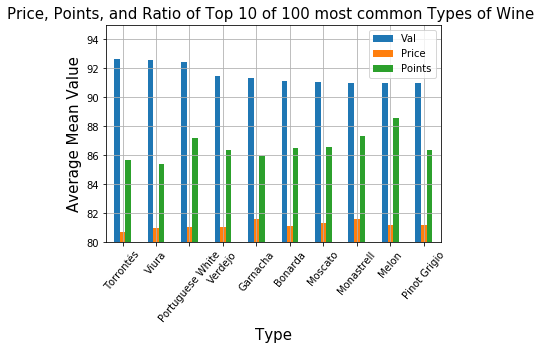

<Figure size 360x1152 with 0 Axes>

In [42]:
z=[]
zz=[]
zzz=[]
for x in sd100bkeys:
    index = sd100bkeys
    z.append(dictionary1[x])
    zz.append(dictionary3[x])
    zzz.append(dictionary5[x])

df2 = pd.DataFrame({'Val': z,
                    'Price': zz, 'Points': zzz},index=index)

ax = df2.plot.bar(rot=0)
ax.set_ylim([80,95])
plt.ylabel('Average Mean Value', fontsize=15)
plt.xlabel('Type', fontsize=15)
plt.title('Price, Points, and Ratio of Top 10 of 100 most common Types of Wine ', fontsize=15)
plt.legend(loc = 1)
plt.grid(True)
plt.xticks(rotation=50)
plt.figure(figsize=(5,16))
plt.show()

### 2) Of the 100 most common categories of wine, the worst 10 ranked by value, showing value, price, and points scaled between 80-100.

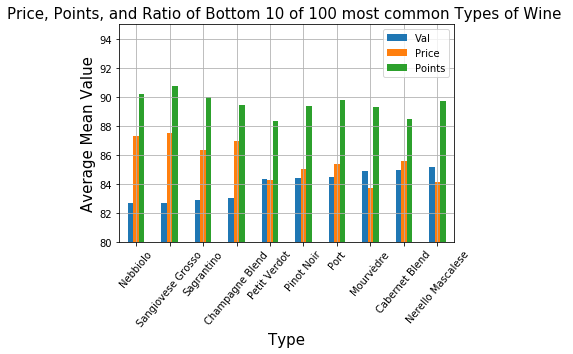

In [43]:
j=[]
jj=[]
jjj=[]
for x in sd100wkeys:
    index = sd100wkeys
    j.append(dictionary1[x])
    jj.append(dictionary3[x])
    jjj.append(dictionary5[x])
df3 = pd.DataFrame({'Val': j,
                    'Price': jj, 'Points': jjj},index=index)
ax = df3.plot.bar(rot=0)
ax.set_ylim([80,95])
plt.ylabel('Average Mean Value', fontsize=15)
plt.xlabel('Type', fontsize=15)
plt.title('Price, Points, and Ratio of Bottom 10 of 100 most common Types of Wine ', fontsize=15)
plt.legend(loc = 1)
plt.grid(True)

plt.xticks(rotation=50)
plt.show()

### 3) Of the 10 most common categories of wine, the top 10 ranked by value, showing value, price, and points scaled between 80-100.

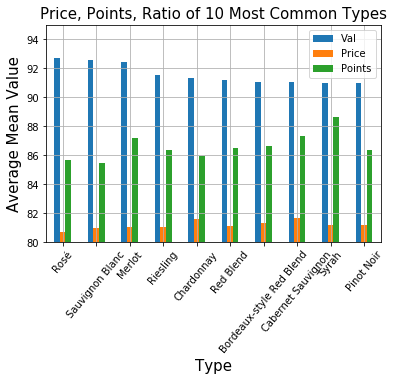

In [44]:
g=[]
gg=[]
ggg=[]
for x in sd10keys:
    index = sd10keys
    g.append(dictionary2[x])
    gg.append(dictionary4[x])
    ggg.append(dictionary6[x])
df4 = pd.DataFrame({'Val': z,
                    'Price': zz, 'Points': zzz},index=index)
ax = df4.plot.bar(rot=0)
ax.set_ylim([80,95])
plt.ylabel('Average Mean Value', fontsize=15)
plt.xlabel('Type', fontsize=15)
plt.title('Price, Points, Ratio of 10 Most Common Types', fontsize=15)
plt.legend(loc = 1)
plt.grid(True)
plt.xticks(rotation=50)
plt.show()

### Now to move on the plotting the same features by country.

In [45]:
df.country.value_counts()

US                        53430
France                    17194
Italy                     16579
Spain                      6286
Portugal                   4503
Chile                      4209
Argentina                  3649
Austria                    2795
Australia                  2201
Germany                    2047
New Zealand                1374
South Africa               1275
Israel                      487
Greece                      458
Canada                      254
Hungary                     142
Bulgaria                    136
Uruguay                     109
Turkey                       90
Georgia                      84
Slovenia                     77
Romania                      73
Croatia                      71
Mexico                       69
England                      69
None                         57
Moldova                      56
Brazil                       47
Lebanon                      35
Morocco                      28
Peru                         16
Serbia  

In [46]:
toplocs = df.country.value_counts().index.tolist()[0:12]

In [47]:
toplocs

['US',
 'France',
 'Italy',
 'Spain',
 'Portugal',
 'Chile',
 'Argentina',
 'Austria',
 'Australia',
 'Germany',
 'New Zealand',
 'South Africa']

In [48]:
locmeansval = []
locmeansprice = []
locmeanspoints = []

for x in toplocs:
    zz = df.loc[df['country'] == x]
    locmeansval.append(zz['OValue Ratio'].mean())
    locmeanspoints.append(zz['points'].mean())
    locmeansprice.append(zz['OPrice'].mean())              

print(locmeansval)
print(locmeansprice)
print(locmeanspoints)


[3.3015626788522052, 3.905300560958916, 3.4921477273940873, 4.791584183411538, 5.121282148016056, 5.55085290927206, 5.04418116085772, 3.813556667408678, 4.129626773807764, 3.784688949063286, 4.130920754118438, 4.937994749964032]
[35.53909788508329, 32.94224729556822, 36.57120453585862, 26.05361119949093, 24.637130801687764, 20.441910192444762, 24.10386407234859, 30.299821109123435, 31.64652430713312, 33.14753297508549, 26.987627365356623, 24.12235294117647]
[88.56187535092644, 88.59282307781784, 88.5610712346945, 87.30114540248171, 88.48745280923829, 86.58707531480161, 86.77445875582352, 90.18890876565295, 88.60245343025898, 89.70639960918417, 88.31732168850073, 87.84235294117647]


In [49]:
toplocdf = pd.DataFrame(
    {'country': toplocs,
     'value': locmeansval,
     'price': locmeansprice,
   'points': locmeanspoints
    })

In [50]:
toplocdf.head()

,country,value,price,points
0,US,3.301563,35.539098,88.561875
1,France,3.905301,32.942247,88.592823
2,Italy,3.492148,36.571205,88.561071
3,Spain,4.791584,26.053611,87.301145
4,Portugal,5.121282,24.637131,88.487453


In [51]:
toplocdf.sort_values(by=['value'], ascending=False)

,country,value,price,points
5,Chile,5.550853,20.441910,86.587075
4,Portugal,5.121282,24.637131,88.487453
6,Argentina,5.044181,24.103864,86.774459
11,South Africa,4.937995,24.122353,87.842353
3,Spain,4.791584,26.053611,87.301145
10,New Zealand,4.130921,26.987627,88.317322
8,Australia,4.129627,31.646524,88.602453
1,France,3.905301,32.942247,88.592823
7,Austria,3.813557,30.299821,90.188909
9,Germany,3.784689,33.147533,89.706400


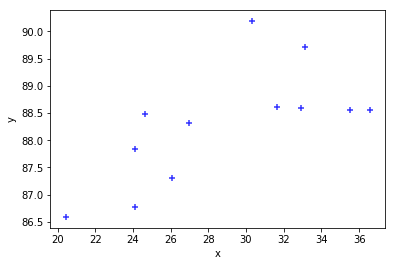

In [52]:
dfscat = pd.DataFrame({
'x': locmeansprice,
'y': locmeanspoints,
'group': toplocs
})
sns.regplot(data=dfscat, x="x", y="y", fit_reg=False, marker="+", color="blue")
#sns.plt.show()

### This scatterplot shows price v. points for the top 10 most common countries of origin of the bottles of wine.

KeyError: 12

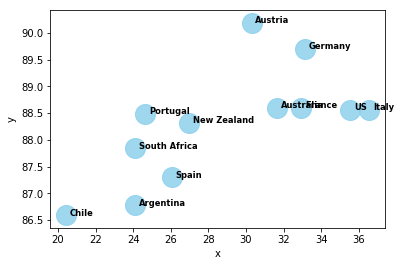

In [53]:
# basic plot
p1=sns.regplot(data=dfscat, x='x', y='y', fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':400})
# add annotations one by one with a loop
for line in range(0,df.shape[0]):
     p1.text(dfscat.x[line]+.2, dfscat.y[line], dfscat.group[line], horizontalalignment='left', size='small', color='black', weight='semibold')
sns.set(rc={'figure.figsize':(10,7)})
plt.ylabel('Point Score', fontsize=15)
plt.xlabel('Price', fontsize=15)
plt.title("Price vs Score based on Country" , fontsize=20)
plt.show()



In [54]:
df.Positive.value_counts()

0    117983
Name: Positive, dtype: int64

In [55]:
scoremean

88.42188055383343

In [56]:
df['points'].iloc[13] = 1

C:\Users\Brian\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


# Modeling the Data

## The clasifier this project aims to build will aim to classify if a bottle has a positive or negative review based on the description of the bottle.

#### Engineering a features 'Positive', which designates whether the score of the bottle is above or below the average points will make classificationeasier.

In [57]:
#df[(df.points > 88)]['Positive'] = 1
for x in range(1, len(df['Positive'])):
    if df['points'].iloc[x] > 88:
        df['Positive'].iloc[x] = 1

C:\Users\Brian\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [58]:
df.Positive.value_counts()

0    62702
1    55281
Name: Positive, dtype: int64

In [59]:
dfnlp = pd.concat([df['description'], df['Positive']], axis=1, keys=['Description', 'Positive'])

In [60]:
dfnlp.head()

,Description,Positive
1,"This is ripe and fruity, a wine that is smooth...",0
2,"Tart and snappy, the flavors of lime flesh and...",0
3,"Pineapple rind, lemon pith and orange blossom ...",0
4,"Much like the regular bottling from 2012, this...",0
5,Blackberry and raspberry aromas show a typical...,0


In [61]:
dfnlp.Positive.value_counts()

0    62702
1    55281
Name: Positive, dtype: int64

In [62]:
dfnlp.head()

,Description,Positive
1,"This is ripe and fruity, a wine that is smooth...",0
2,"Tart and snappy, the flavors of lime flesh and...",0
3,"Pineapple rind, lemon pith and orange blossom ...",0
4,"Much like the regular bottling from 2012, this...",0
5,Blackberry and raspberry aromas show a typical...,0


In [63]:
dfnlp['Description'].head()

1    This is ripe and fruity, a wine that is smooth...
2    Tart and snappy, the flavors of lime flesh and...
3    Pineapple rind, lemon pith and orange blossom ...
4    Much like the regular bottling from 2012, this...
5    Blackberry and raspberry aromas show a typical...
Name: Description, dtype: object

#### This code cleans the text in the descriptions and prepares it for the NLP -- Sentiment Analysis process.

In [64]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text):
    text = text.lower()
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    text = [word for word in text if not any(c.isdigit() for c in word)]
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    text = [t for t in text if len(t) > 0]
    pos_tags = pos_tag(text)
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    text = [t for t in text if len(t) > 1]
    text = " ".join(text)
    return(text)

dfnlp.head(2)

,Description,Positive
1,"This is ripe and fruity, a wine that is smooth...",0
2,"Tart and snappy, the flavors of lime flesh and...",0


Now to apply it to our text corpus

In [65]:
dfnlp["review_clean"] = dfnlp["Description"].apply(lambda x: clean_text(x))

In [66]:
dfnlp.head(2)

,Description,Positive,review_clean
1,"This is ripe and fruity, a wine that is smooth...",0,ripe fruity wine smooth still structure firm t...
2,"Tart and snappy, the flavors of lime flesh and...",0,tart snappy flavor lime flesh rind dominate gr...


### Now to add some features that will be used in sentiment Analysis.

In [67]:
sid = SentimentIntensityAnalyzer()
dfnlp["sentiments"] = dfnlp["Description"].apply(lambda x: sid.polarity_scores(x))
dfnlp = pd.concat([dfnlp.drop(['sentiments'], axis=1), dfnlp['sentiments'].apply(pd.Series)], axis=1)

In [68]:
dfnlp.head(2)

,Description,Positive,review_clean,neg,neu,pos,compound
1,"This is ripe and fruity, a wine that is smooth...",0,ripe fruity wine smooth still structure firm t...,0.000,0.868,0.132,0.6486
2,"Tart and snappy, the flavors of lime flesh and...",0,tart snappy flavor lime flesh rind dominate gr...,0.053,0.947,0.000,-0.1280


In [69]:
dfnlp["nb_chars"] = dfnlp["Description"].apply(lambda x: len(x))
dfnlp["nb_words"] = dfnlp["Description"].apply(lambda x: len(x.split(" ")))

In [70]:
dfnlp["review_clean1"] = dfnlp["review_clean"]
dfnlp.head()

,Description,Positive,review_clean,neg,neu,pos,compound,nb_chars,nb_words,review_clean1
1,"This is ripe and fruity, a wine that is smooth...",0,ripe fruity wine smooth still structure firm t...,0.000,0.868,0.132,0.6486,227,39,ripe fruity wine smooth still structure firm t...
2,"Tart and snappy, the flavors of lime flesh and...",0,tart snappy flavor lime flesh rind dominate gr...,0.053,0.947,0.000,-0.1280,186,28,tart snappy flavor lime flesh rind dominate gr...
3,"Pineapple rind, lemon pith and orange blossom ...",0,pineapple rind lemon pith orange blossom start...,0.000,0.926,0.074,0.3400,199,33,pineapple rind lemon pith orange blossom start...
4,"Much like the regular bottling from 2012, this...",0,much like regular bottle come across rather ro...,0.000,0.805,0.195,0.8176,249,41,much like regular bottle come across rather ro...
5,Blackberry and raspberry aromas show a typical...,0,blackberry raspberry aromas show typical navar...,0.000,0.960,0.040,0.1655,261,42,blackberry raspberry aromas show typical navar...



#### Now to vectorize the text, training a Doc2Vec model.

In [71]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(dfnlp["review_clean"].apply(lambda x: x.split(" ")))]
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)
doc2vec_df = dfnlp["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
dfnlp = pd.concat([dfnlp, doc2vec_df], axis=1)

In [72]:
dfnlp.head(1)

,Description,Positive,review_clean,neg,neu,pos,compound,nb_chars,nb_words,review_clean1,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
1,"This is ripe and fruity, a wine that is smooth...",0,ripe fruity wine smooth still structure firm t...,0.0,0.868,0.132,0.6486,227,39,ripe fruity wine smooth still structure firm t...,-0.018457,0.085813,0.099359,-0.023332,0.241067


In [ ]:
# add tf-idfs columns
#from sklearn.feature_extraction.text import TfidfVectorizer
#tfidf = TfidfVectorizer(min_df = 10)
#tfidf_result = tfidf.fit_transform(dfnlp["review_clean"]).toarray()
#tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
#tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
#tfidf_df.index = reviews_df.index
#dfnlp = pd.concat([dfnlp, tfidf_df], axis=1)

In [73]:
dfnlp["Positive"].value_counts(normalize = True)

0    0.531449
1    0.468551
Name: Positive, dtype: float64

In [74]:
dfnlp.head(2)

,Description,Positive,review_clean,neg,neu,pos,compound,nb_chars,nb_words,review_clean1,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
1,"This is ripe and fruity, a wine that is smooth...",0,ripe fruity wine smooth still structure firm t...,0.000,0.868,0.132,0.6486,227,39,ripe fruity wine smooth still structure firm t...,-0.018457,0.085813,0.099359,-0.023332,0.241067
2,"Tart and snappy, the flavors of lime flesh and...",0,tart snappy flavor lime flesh rind dominate gr...,0.053,0.947,0.000,-0.1280,186,28,tart snappy flavor lime flesh rind dominate gr...,0.007132,0.150873,0.008622,-0.071141,0.201278


#### A nice visualization to understand the text corpus is a word cloud, showing the most common and important words in the description column.

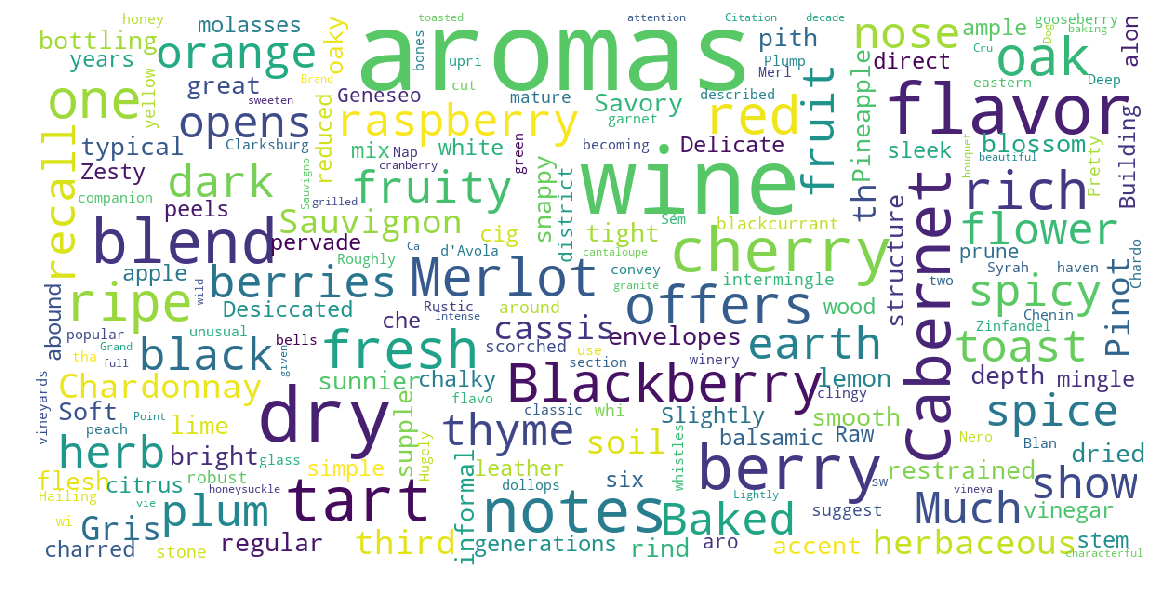

In [75]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(dfnlp["Description"])

#### Take a look at the most positive and most negative descriptions.

In [76]:
dfnlp[dfnlp["nb_words"] >= 5].sort_values("pos", ascending = False)[["Description", "pos"]].head(10)

,Description,pos
117686,"A fine, clean and intense sparkling wine, with...",0.619
26305,"The honey, orange, pineapple-jam and vanilla f...",0.605
67941,"Fine fresh fruits, bright with good acidity an...",0.580
89959,Apple fruitiness dominates this fresh sparklin...,0.572
59927,"On the fresh side, with crisp bright, lively a...",0.558
93923,"Fine and fresh, brightened by grapefruit, lemo...",0.553
100216,Lemon plays on the nose alongside hints of sho...,0.551
2739,"This is a very simple, friendly, fresh and liv...",0.549
110129,"Made exclusively from Sangiovese, Cipresso is ...",0.545
91176,"A just off-dry rosé with great fresh fruit, at...",0.538


In [77]:
dfnlp[dfnlp["nb_words"] >= 5].sort_values("neg", ascending = False)[["Description", "neg"]].head(10)

,Description,neg
26885,"This is sour, bitter and just all-around dull ...",0.509
87189,Disagreeable for its harsh acidity and vegetal...,0.453
15608,"Smells baked and hot, tastes harsh and dry, a ...",0.443
99910,This is a yeasty wine that shows a bitter almo...,0.372
103989,This suffers from major problems. It has all t...,0.371
79700,"This wine combines green, herbal overtones wit...",0.354
108268,"Dry, dark-hued tannins cut through the wine, g...",0.344
3622,"Soft, with a severe cut of acidity slicing thr...",0.343
123521,"A pruny, overripe Merlot that feels harsh and ...",0.341
82547,"The vintage was terribly difficult, with cold ...",0.336


#### Plotting the density plots

C:\Users\Brian\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


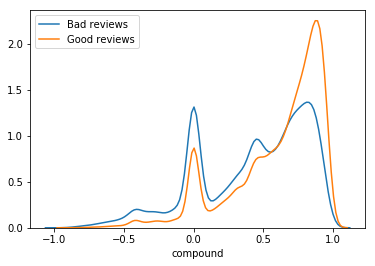

In [78]:
for x in [0, 1]:
    subset = dfnlp[dfnlp['Positive'] == x]
    if x == 0:
        label = "Bad reviews"
    else:
        label = "Good reviews"
    sns.distplot(subset['compound'], hist = False, label = label)

#### CHeck out the feature importance for feature selection. Then, split the data into test and train data in order to train and then test the model.

In [89]:
# feature selection
label = "Positive"
ignore_cols = [label, "Description", "review_clean", "review_clean1"]
features = [c for c in dfnlp.columns if c not in ignore_cols]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dfnlp[features], dfnlp[label], test_size = 0.20, random_state = 42)


#### Now to train the classifier, a random forrest will provide a good method of determining whether a review is good or bad.

In [90]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

# show feature importance
feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(20)

,feature,importance
4,nb_chars,0.204460
5,nb_words,0.114639
6,doc2vec_vector_0,0.089630
8,doc2vec_vector_2,0.088627
9,doc2vec_vector_3,0.087937
10,doc2vec_vector_4,0.087554
7,doc2vec_vector_1,0.086998
3,compound,0.085950
2,pos,0.067145
1,neu,0.062102


#### This code plots the ROC graphs, to see the trade off between False Positives and True positives.


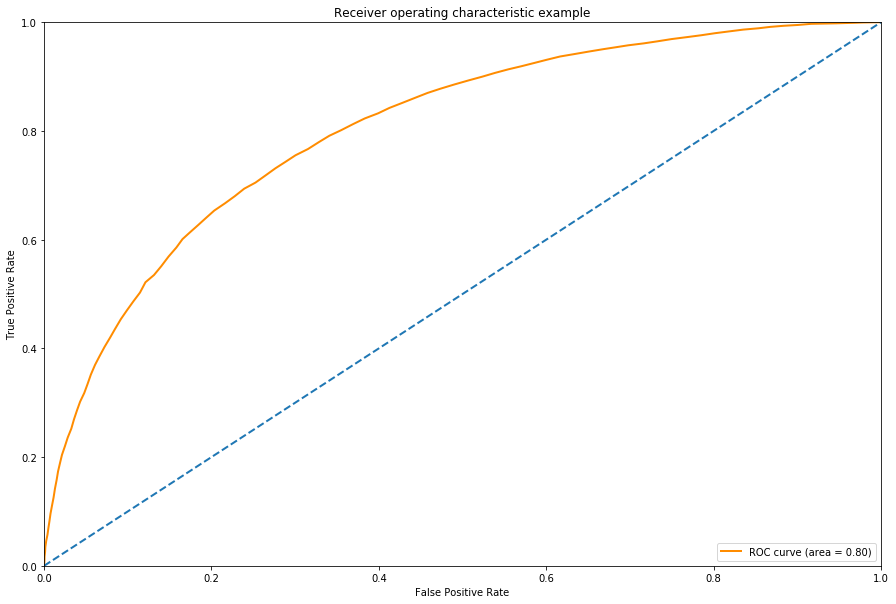

In [91]:
y_pred = [x[1] for x in rf.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)
roc_auc = auc(fpr, tpr)
plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#### Now to plot the tradeoff between Precision and recall of the model

Text(0.5,1,'2-class Precision-Recall curve: AP=0.77')

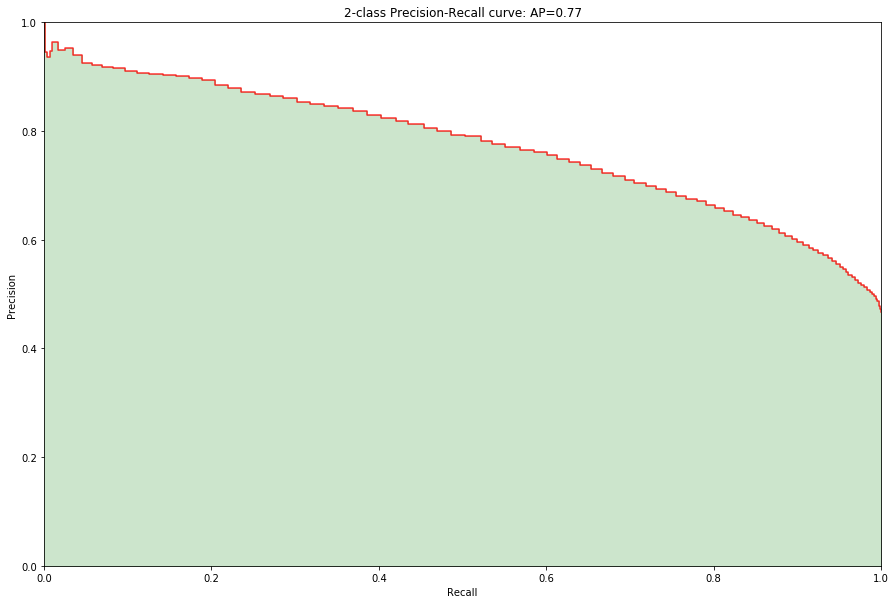

In [92]:
average_precision = average_precision_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='r', alpha=0.8,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='g', **step_kwargs)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

# Conclusion  --  Intepreting the Data

#### Now to look into the performance of the model by looking at the accuracy, testing and training,and building a confusion matrix to visualize the proportion of True Positive and negatives, and false Positives and negatives.

In [93]:
average_precision

0.7737350542869381

In [94]:
rf.score(X_train, y_train)
#X_train, X_test, y_train, y_test

1.0

In [95]:
rf.score(X_test, y_test)

0.7295418909183371

In [96]:
y_hat_test = rf.predict(X_test)

In [97]:
cnf_matrix = confusion_matrix(y_hat_test, y_test)
print('Confusion Matrix:\n',cnf_matrix)

Confusion Matrix:
 [[9574 3373]
 [3009 7641]]


Confusion matrix, without normalization
[[9574 3373]
 [3009 7641]]
Normalized confusion matrix
[[0.74 0.26]
 [0.28 0.72]]


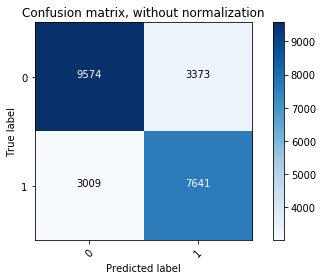

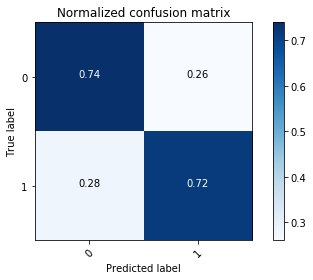

In [98]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

np.set_printoptions(precision=2)
class_names = ['0', '1']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## The performance of the model performed around 23% better than random guessing, which is fairly good considering the bredth of the task. Overall, the description can be used to classify the outcome of the review around 73% of the time.

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

In [102]:
X = dfnlp.review_clean1
Y = dfnlp['Positive']
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [103]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [104]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [105]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [106]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
__________

In [107]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 80228 samples, validate on 20057 samples
Epoch 1/10
80228/80228 [==============================] - 136s 2ms/step - loss: 0.4526 - acc: 0.7836 - val_loss: 0.4121 - val_acc: 0.8044
Epoch 2/10
80228/80228 [==============================] - 135s 2ms/step - loss: 0.4128 - acc: 0.8078 - val_loss: 0.4189 - val_acc: 0.8031


In [108]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [109]:
accr = model.evaluate(test_sequences_matrix,Y_test)

17698/17698 [==============================] - 10s 582us/step


In [110]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.417
  Accuracy: 0.804
